Datos de MSFT cargados correctamente.


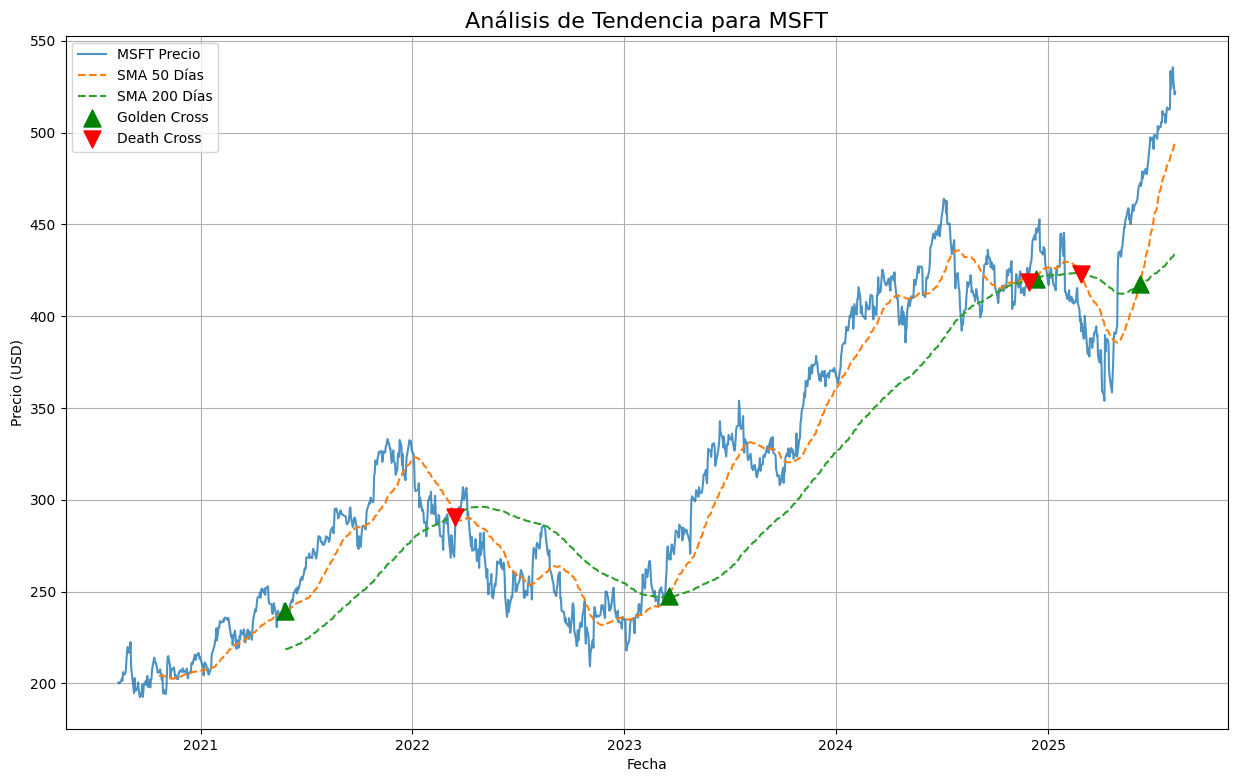

In [5]:
# =================================================================
# Celda 15: Medias Móviles y Señales de Cruce
# =================================================================
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import config as cfg

# --- Cargamos los datos de nuestra empresa principal ---
try:
    prices = pd.read_csv('datos_empresas.csv', index_col='Date', parse_dates=True)[[cfg.EMPRESA_PRINCIPAL]]
    print(f"Datos de {cfg.EMPRESA_PRINCIPAL} cargados correctamente.")
except (FileNotFoundError, KeyError):
    print(f"Error: No se pudo cargar los datos para {cfg.EMPRESA_PRINCIPAL}. Verifica el archivo y la configuración.")

# --- Cálculo de Medias Móviles Simples (SMA) ---
prices['SMA50'] = prices[cfg.EMPRESA_PRINCIPAL].rolling(window=50).mean()
prices['SMA200'] = prices[cfg.EMPRESA_PRINCIPAL].rolling(window=200).mean()

# --- Identificación de los cruces ---
# Creamos una señal: 1 si SMA50 > SMA200, 0 si no.
prices['Signal'] = np.where(prices['SMA50'] > prices['SMA200'], 1, 0)
# Buscamos los puntos donde la señal cambia
prices['Cross'] = prices['Signal'].diff()

golden_crosses = prices[prices['Cross'] == 1]
death_crosses = prices[prices['Cross'] == -1]

# --- Gráfico ---
plt.figure(figsize=(15, 9))
plt.plot(prices[cfg.EMPRESA_PRINCIPAL], label=f'{cfg.EMPRESA_PRINCIPAL} Precio', alpha=0.8)
plt.plot(prices['SMA50'], label='SMA 50 Días', linestyle='--')
plt.plot(prices['SMA200'], label='SMA 200 Días', linestyle='--')

# Marcamos los cruces en el gráfico
plt.scatter(golden_crosses.index, golden_crosses['SMA50'], marker='^', color='green', s=150, label='Golden Cross', zorder=5)
plt.scatter(death_crosses.index, death_crosses['SMA50'], marker='v', color='red', s=150, label='Death Cross', zorder=5)

plt.title(f'Análisis de Tendencia para {cfg.EMPRESA_PRINCIPAL}', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid(True)
plt.show()

Rendimiento Final de la Estrategia 'Buy & Hold': 160.47%
Rendimiento Final de la Estrategia de Cruces: 84.52%


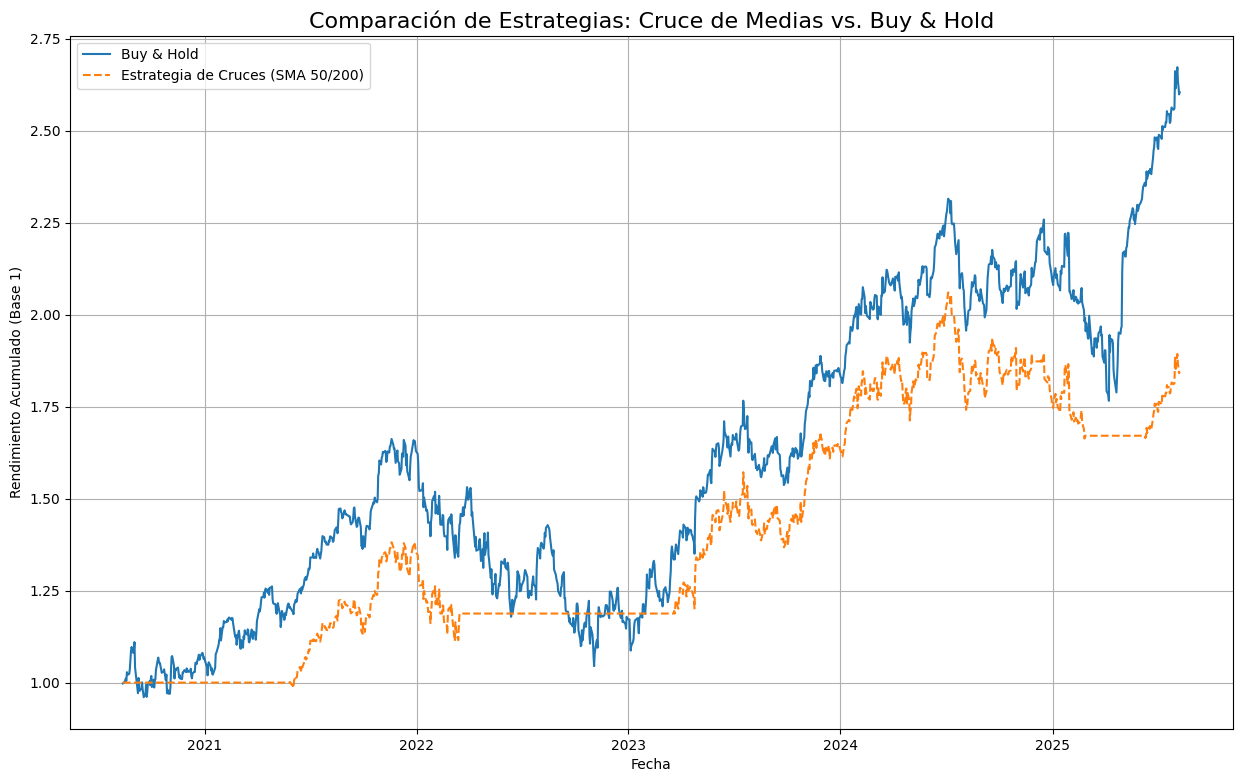

In [6]:
# =================================================================
# Celda 16: Backtesting de Estrategia de Cruces
# =================================================================

# --- Estrategia 1: Buy & Hold ---
# Calculamos los retornos diarios de la acción
prices['Returns'] = prices[cfg.EMPRESA_PRINCIPAL].pct_change()
# El rendimiento acumulado es el producto acumulado de (1 + retorno diario)
prices['BuyHold_Cumulative'] = (1 + prices['Returns']).cumprod()


# --- Estrategia 2: Cruce de Medias Móviles ---
# Usamos la columna 'Signal' de la celda anterior. 
# La señal de hoy determina la posición de mañana, por eso usamos .shift(1)
prices['Strategy_Returns'] = prices['Returns'] * prices['Signal'].shift(1)
prices['Strategy_Cumulative'] = (1 + prices['Strategy_Returns']).cumprod()


# --- Resultados y Gráfico de Comparación ---
buy_hold_return = (prices['BuyHold_Cumulative'].iloc[-1] - 1) * 100
strategy_return = (prices['Strategy_Cumulative'].iloc[-1] - 1) * 100

print(f"Rendimiento Final de la Estrategia 'Buy & Hold': {buy_hold_return:.2f}%")
print(f"Rendimiento Final de la Estrategia de Cruces: {strategy_return:.2f}%")

# Gráfico de la evolución de ambas estrategias
plt.figure(figsize=(15, 9))
plt.plot(prices['BuyHold_Cumulative'], label='Buy & Hold')
plt.plot(prices['Strategy_Cumulative'], label='Estrategia de Cruces (SMA 50/200)', linestyle='--')

plt.title('Comparación de Estrategias: Cruce de Medias vs. Buy & Hold', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Rendimiento Acumulado (Base 1)')
plt.legend()
plt.grid(True)
plt.show()

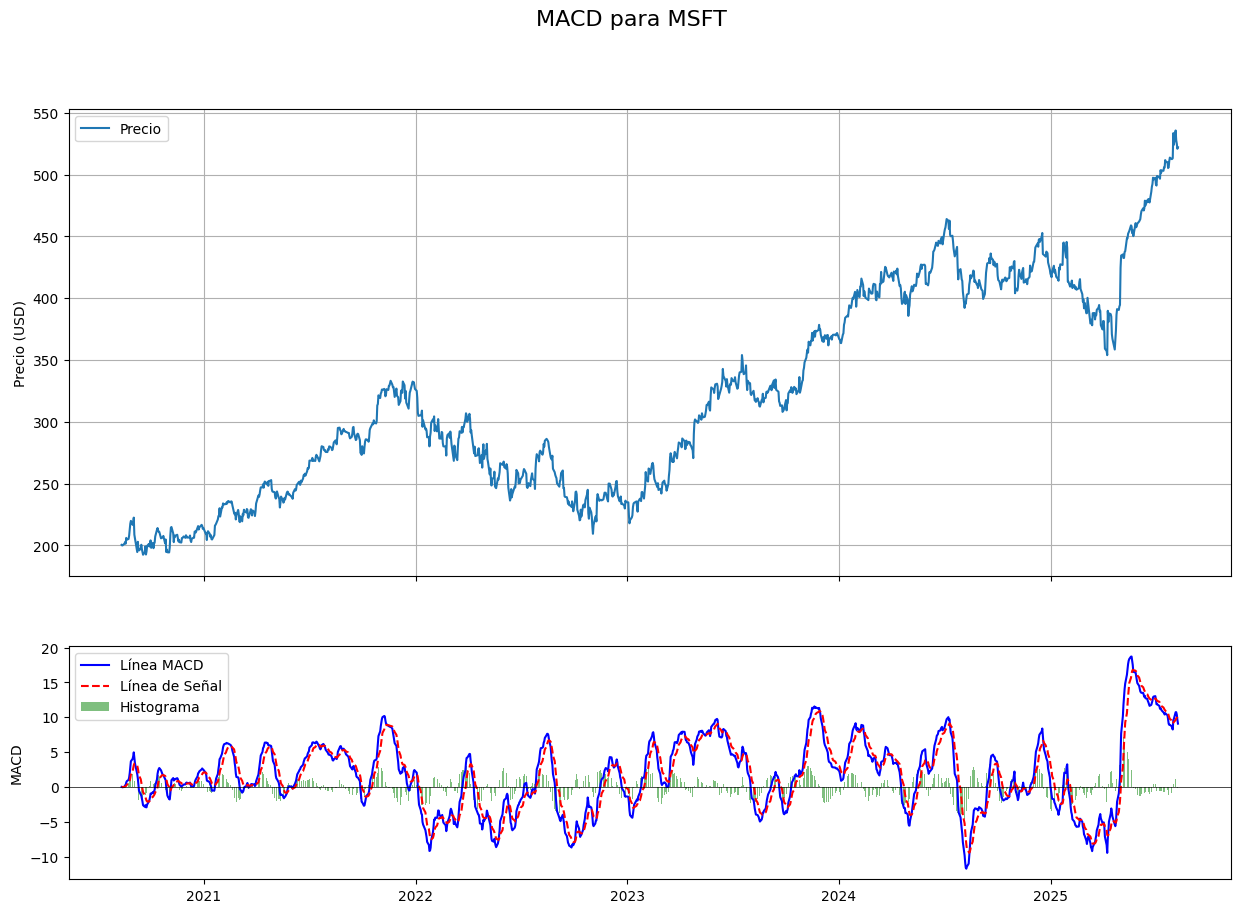

In [8]:
# =================================================================
# Celda 17: Cálculo y Gráfico del MACD
# =================================================================
import pandas as pd
import matplotlib.pyplot as plt
import config as cfg

# --- Usamos el DataFrame 'prices' de la celda 15 ---
# Si no lo tienes cargado, descomenta las siguientes líneas:
# try:
#     prices = pd.read_csv('datos_empresas.csv', index_col='Date', parse_dates=True)[[cfg.EMPRESA_PRINCIPAL]]
# except (FileNotFoundError, KeyError):
#     print("Error al cargar los datos.")

# --- Cálculo del MACD ---
# 1. Calcular EMAs de 12 y 26 períodos
ema_12 = prices[cfg.EMPRESA_PRINCIPAL].ewm(span=12, adjust=False).mean()
ema_26 = prices[cfg.EMPRESA_PRINCIPAL].ewm(span=26, adjust=False).mean()
# 2. Calcular la línea MACD
prices['MACD'] = ema_12 - ema_26
# 3. Calcular la línea de Señal
prices['Signal_Line'] = prices['MACD'].ewm(span=9, adjust=False).mean()
# 4. Calcular el Histograma
prices['Histogram'] = prices['MACD'] - prices['Signal_Line']

# --- Gráfico ---
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle(f'MACD para {cfg.EMPRESA_PRINCIPAL}', fontsize=16)

# Gráfico de Precio
axes[0].plot(prices[cfg.EMPRESA_PRINCIPAL], label='Precio')
axes[0].set_ylabel('Precio (USD)')
axes[0].legend()
axes[0].grid(True)

# Gráfico de MACD
axes[1].plot(prices['MACD'], label='Línea MACD', color='blue')
axes[1].plot(prices['Signal_Line'], label='Línea de Señal', color='red', linestyle='--')
axes[1].bar(prices.index, prices['Histogram'], label='Histograma', color='green', alpha=0.5)
axes[1].axhline(0, color='black', linewidth=0.5)
axes[1].set_ylabel('MACD')
axes[1].legend()

plt.show()

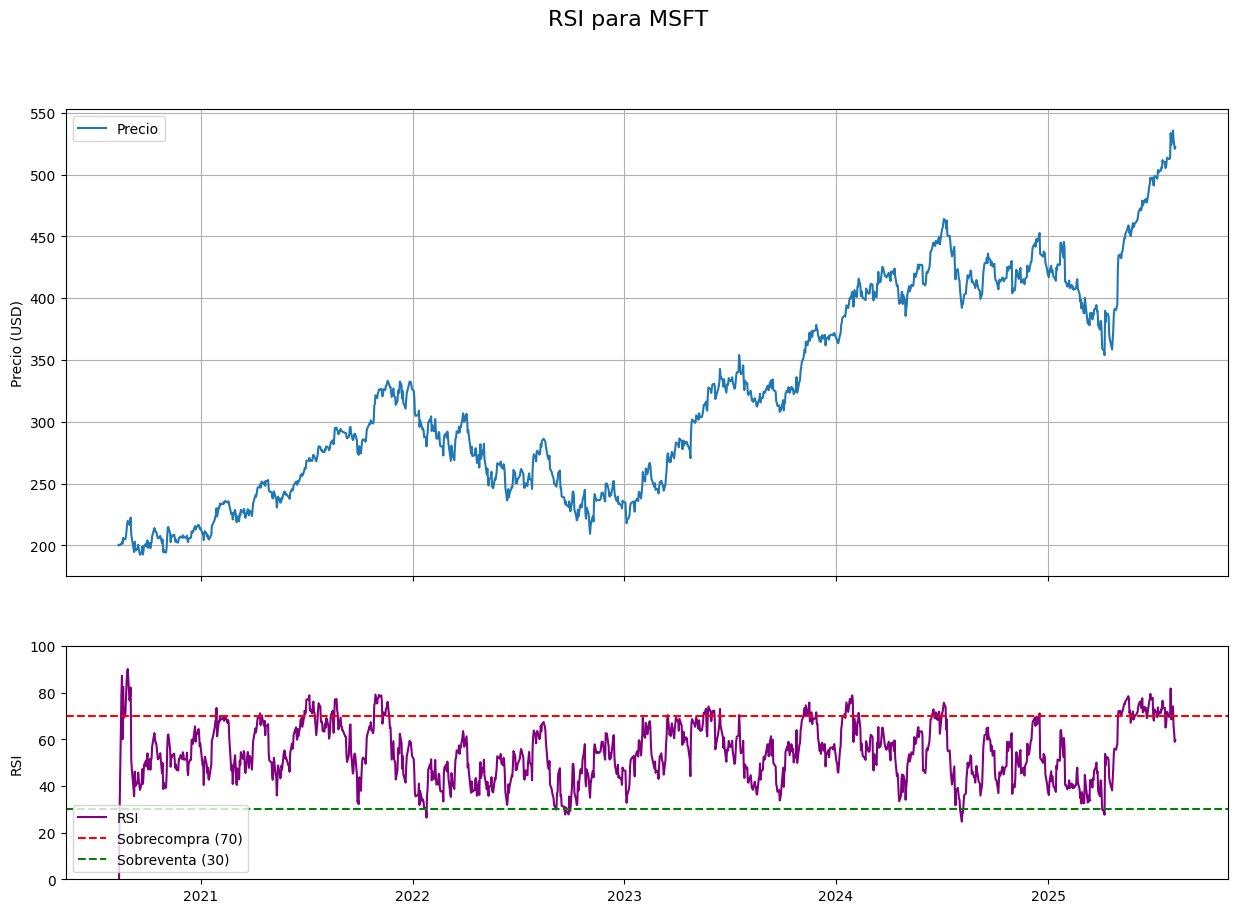

In [9]:
# =================================================================
# Celda 18: Cálculo y Gráfico del RSI
# =================================================================

# --- Cálculo del RSI ---
delta = prices[cfg.EMPRESA_PRINCIPAL].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

# Usamos EMA para el promedio de ganancias y pérdidas
avg_gain = gain.ewm(com=13, adjust=False).mean() # com = 13 es equivalente a un período de 14
avg_loss = loss.ewm(com=13, adjust=False).mean()

rs = avg_gain / avg_loss
prices['RSI'] = 100 - (100 / (1 + rs))

# --- Gráfico ---
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle(f'RSI para {cfg.EMPRESA_PRINCIPAL}', fontsize=16)

# Gráfico de Precio
axes[0].plot(prices[cfg.EMPRESA_PRINCIPAL], label='Precio')
axes[0].set_ylabel('Precio (USD)')
axes[0].legend()
axes[0].grid(True)

# Gráfico de RSI
axes[1].plot(prices['RSI'], label='RSI', color='purple')
axes[1].axhline(70, color='red', linestyle='--', label='Sobrecompra (70)')
axes[1].axhline(30, color='green', linestyle='--', label='Sobreventa (30)')
axes[1].set_ylabel('RSI')
axes[1].set_ylim(0, 100)
axes[1].legend()

plt.show()

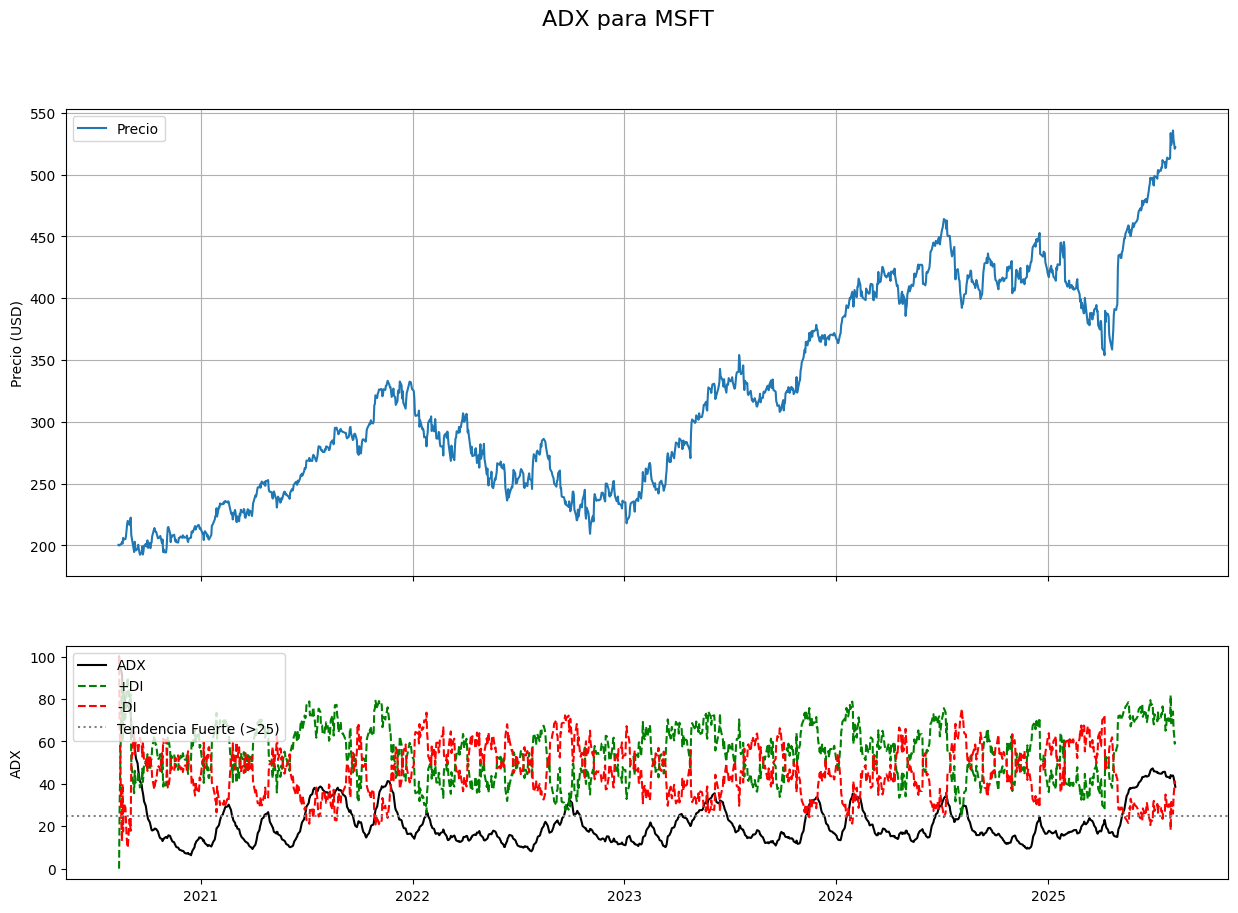

In [10]:
# =================================================================
# Celda 19: Cálculo y Gráfico del ADX
# =================================================================

# --- Cálculo del ADX ---
# (La función es compleja, la encapsulamos para mayor claridad)
def calculate_adx(prices_df, period=14):
    df = prices_df.copy()
    high = prices_df[cfg.EMPRESA_PRINCIPAL] # Usamos el precio de cierre como proxy para high/low/close
    low = prices_df[cfg.EMPRESA_PRINCIPAL]
    close = prices_df[cfg.EMPRESA_PRINCIPAL]
    
    # True Range
    df['H-L'] = high - low
    df['H-PC'] = abs(high - close.shift(1))
    df['L-PC'] = abs(low - close.shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    
    # Directional Movement
    df['+DM'] = np.where((high - high.shift(1)) > (low.shift(1) - low), high - high.shift(1), 0)
    df['-DM'] = np.where((low.shift(1) - low) > (high - high.shift(1)), low.shift(1) - low, 0)
    
    # Smoothed values
    atr = df['TR'].ewm(alpha=1/period, adjust=False).mean()
    plus_di = 100 * (df['+DM'].ewm(alpha=1/period, adjust=False).mean() / atr)
    minus_di = 100 * (df['-DM'].ewm(alpha=1/period, adjust=False).mean() / atr)
    
    # DX y ADX
    dx = 100 * (abs(plus_di - minus_di) / (plus_di + minus_di))
    adx = dx.ewm(alpha=1/period, adjust=False).mean()
    
    return plus_di, minus_di, adx

prices['+DI'], prices['-DI'], prices['ADX'] = calculate_adx(prices[[cfg.EMPRESA_PRINCIPAL]])


# --- Gráfico ---
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle(f'ADX para {cfg.EMPRESA_PRINCIPAL}', fontsize=16)

# Gráfico de Precio
axes[0].plot(prices[cfg.EMPRESA_PRINCIPAL], label='Precio')
axes[0].set_ylabel('Precio (USD)')
axes[0].legend()
axes[0].grid(True)

# Gráfico de ADX
axes[1].plot(prices['ADX'], label='ADX', color='black')
axes[1].plot(prices['+DI'], label='+DI', color='green', linestyle='--')
axes[1].plot(prices['-DI'], label='-DI', color='red', linestyle='--')
axes[1].axhline(25, color='grey', linestyle=':', label='Tendencia Fuerte (>25)')
axes[1].set_ylabel('ADX')
axes[1].legend()

plt.show()

In [11]:
# =================================================================
# Celda 20: Optimización de Parámetros del MACD
# =================================================================
import pandas as pd
import numpy as np
import config as cfg
from itertools import product # Herramienta para crear combinaciones

# --- 1. Función de Backtesting para el MACD ---
def backtest_macd(prices_df, fast, slow, signal):
    """
    Realiza un backtest de una estrategia de cruce de MACD con parámetros específicos.
    Retorna la rentabilidad acumulada final.
    """
    df = prices_df.copy()
    
    # Calcular MACD con los parámetros dados
    ema_fast = df[cfg.EMPRESA_PRINCIPAL].ewm(span=fast, adjust=False).mean()
    ema_slow = df[cfg.EMPRESA_PRINCIPAL].ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    
    # Generar señal de trading (1 si estamos comprados, 0 si estamos fuera)
    df['Signal'] = np.where(macd_line > signal_line, 1, 0)
    
    # Calcular retornos de la estrategia
    df['Returns'] = df[cfg.EMPRESA_PRINCIPAL].pct_change()
    df['Strategy_Returns'] = df['Returns'] * df['Signal'].shift(1)
    
    # Calcular rentabilidad acumulada
    cumulative_return = (1 + df['Strategy_Returns']).cumprod().iloc[-1]
    
    return cumulative_return

# --- 2. Proceso de Optimización (Grid Search) ---
print("Iniciando optimización de parámetros para el MACD...")

# Definimos los rangos de parámetros a probar
fast_range = range(5, 21, 3)    # EMA rápida de 5 a 20, en pasos de 3
slow_range = range(25, 61, 5)   # EMA lenta de 25 a 60, en pasos de 5
signal_range = range(5, 21, 3)    # Línea de señal de 5 a 20, en pasos de 3

# Variables para guardar el mejor resultado
best_return = 0
best_params = {}
combination_count = 0

# Iteramos sobre todas las combinaciones posibles
for fast, slow, signal in product(fast_range, slow_range, signal_range):
    # Aseguramos que la EMA lenta sea mayor que la rápida
    if slow > fast:
        combination_count += 1
        # Ejecutamos el backtest para esta combinación
        current_return = backtest_macd(prices[[cfg.EMPRESA_PRINCIPAL]], fast, slow, signal)
        
        # Si el resultado es mejor que el anterior, lo guardamos
        if current_return > best_return:
            best_return = current_return
            best_params = {'fast': fast, 'slow': slow, 'signal': signal}

print(f"\nOptimización completada. Se probaron {combination_count} combinaciones.")
print("--- Parámetros Óptimos Encontrados ---")
print(f"Mejor Rentabilidad Acumulada: {(best_return - 1) * 100:.2f}%")
print(f"Mejores Parámetros (rápida, lenta, señal): ({best_params.get('fast', 'N/A')}, {best_params.get('slow', 'N/A')}, {best_params.get('signal', 'N/A')})")
print("\nParámetros Estándar (para comparación): (12, 26, 9)")

Iniciando optimización de parámetros para el MACD...

Optimización completada. Se probaron 288 combinaciones.
--- Parámetros Óptimos Encontrados ---
Mejor Rentabilidad Acumulada: 59.09%
Mejores Parámetros (rápida, lenta, señal): (5, 25, 5)

Parámetros Estándar (para comparación): (12, 26, 9)


Gráfico 1: Estructura de la Volatilidad


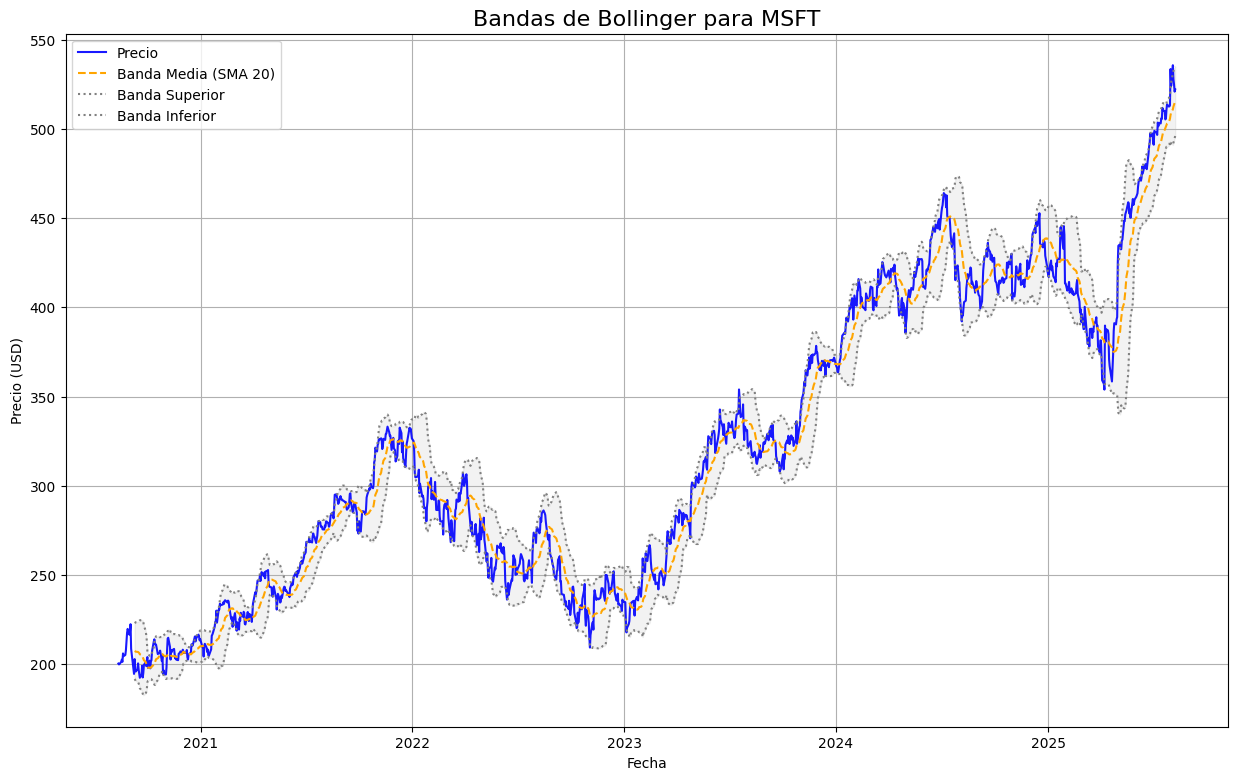


Gráfico 2: Señales de Trading


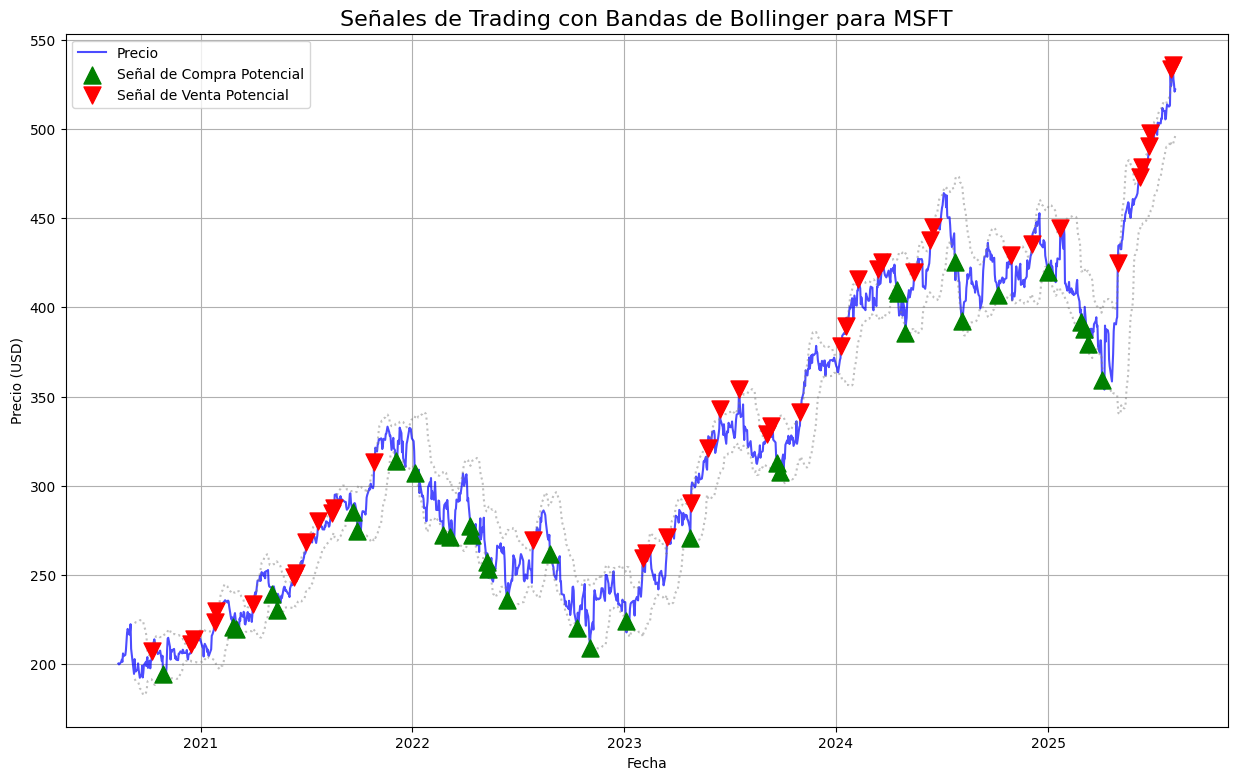

In [14]:
# =================================================================
# Celda 21: Gráficos Separados de Bandas de Bollinger y Señales
# =================================================================
import pandas as pd
import matplotlib.pyplot as plt
import config as cfg

# --- Usamos el DataFrame 'prices' con los cálculos ya hechos ---
# Asegúrate de haber ejecutado una de las celdas anteriores que calcula las bandas.

# --- Gráfico 1: Estructura de las Bandas de Bollinger ---
print("Gráfico 1: Estructura de la Volatilidad")
plt.figure(figsize=(15, 9))
plt.plot(prices[cfg.EMPRESA_PRINCIPAL], label='Precio', color='blue', alpha=0.9)
plt.plot(prices['SMA20'], label='Banda Media (SMA 20)', color='orange', linestyle='--')
plt.plot(prices['UpperBand'], label='Banda Superior', color='gray', linestyle=':')
plt.plot(prices['LowerBand'], label='Banda Inferior', color='gray', linestyle=':')
plt.fill_between(prices.index, prices['LowerBand'], prices['UpperBand'], color='gray', alpha=0.1)

plt.title(f'Bandas de Bollinger para {cfg.EMPRESA_PRINCIPAL}', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid(True)
plt.show()


# --- Gráfico 2: Señales de Compra y Venta ---
print("\nGráfico 2: Señales de Trading")
# Identificamos las señales si no se hizo antes
buy_signals = prices[(prices[cfg.EMPRESA_PRINCIPAL].shift(1) > prices['LowerBand'].shift(1)) & (prices[cfg.EMPRESA_PRINCIPAL] < prices['LowerBand'])]
sell_signals = prices[(prices[cfg.EMPRESA_PRINCIPAL].shift(1) < prices['UpperBand'].shift(1)) & (prices[cfg.EMPRESA_PRINCIPAL] > prices['UpperBand'])]

plt.figure(figsize=(15, 9))
# Graficamos solo el precio como línea principal
plt.plot(prices[cfg.EMPRESA_PRINCIPAL], label='Precio', color='blue', alpha=0.7)
# Añadimos las bandas con menos opacidad para dar contexto
plt.plot(prices['UpperBand'], color='gray', linestyle=':', alpha=0.5)
plt.plot(prices['LowerBand'], color='gray', linestyle=':', alpha=0.5)

# Marcamos las señales en el gráfico
plt.scatter(buy_signals.index, buy_signals[cfg.EMPRESA_PRINCIPAL], marker='^', color='green', s=150, label='Señal de Compra Potencial', zorder=5)
plt.scatter(sell_signals.index, sell_signals[cfg.EMPRESA_PRINCIPAL], marker='v', color='red', s=150, label='Señal de Venta Potencial', zorder=5)

plt.title(f'Señales de Trading con Bandas de Bollinger para {cfg.EMPRESA_PRINCIPAL}', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
# =================================================================
# Celda 23: Análisis de las Condiciones de los Indicadores
# =================================================================

# Extraemos los datos de los indicadores en los puntos de compra óptimos
optimal_buys = prices.iloc[valleys]
# Extraemos los datos de los indicadores en los puntos de venta óptimos
optimal_sells = prices.iloc[peaks]

# Calculamos los valores promedio de los indicadores en esos momentos
avg_buy_conditions = optimal_buys[['RSI', 'ADX', 'Histogram']].mean()
avg_sell_conditions = optimal_sells[['RSI', 'ADX', 'Histogram']].mean()

print("--- Condiciones Promedio en Puntos de COMPRA Óptimos ---")
print(avg_buy_conditions)
print("\n--- Condiciones Promedio en Puntos de VENTA Óptimos ---")
print(avg_sell_conditions)

--- Condiciones Promedio en Puntos de COMPRA Óptimos ---
RSI          38.734177
ADX          21.710785
Histogram    -1.714162
dtype: float64

--- Condiciones Promedio en Puntos de VENTA Óptimos ---
RSI          71.049200
ADX          29.045100
Histogram     1.596462
dtype: float64


Generando gráfico de la estrategia de ciclos de mercado...


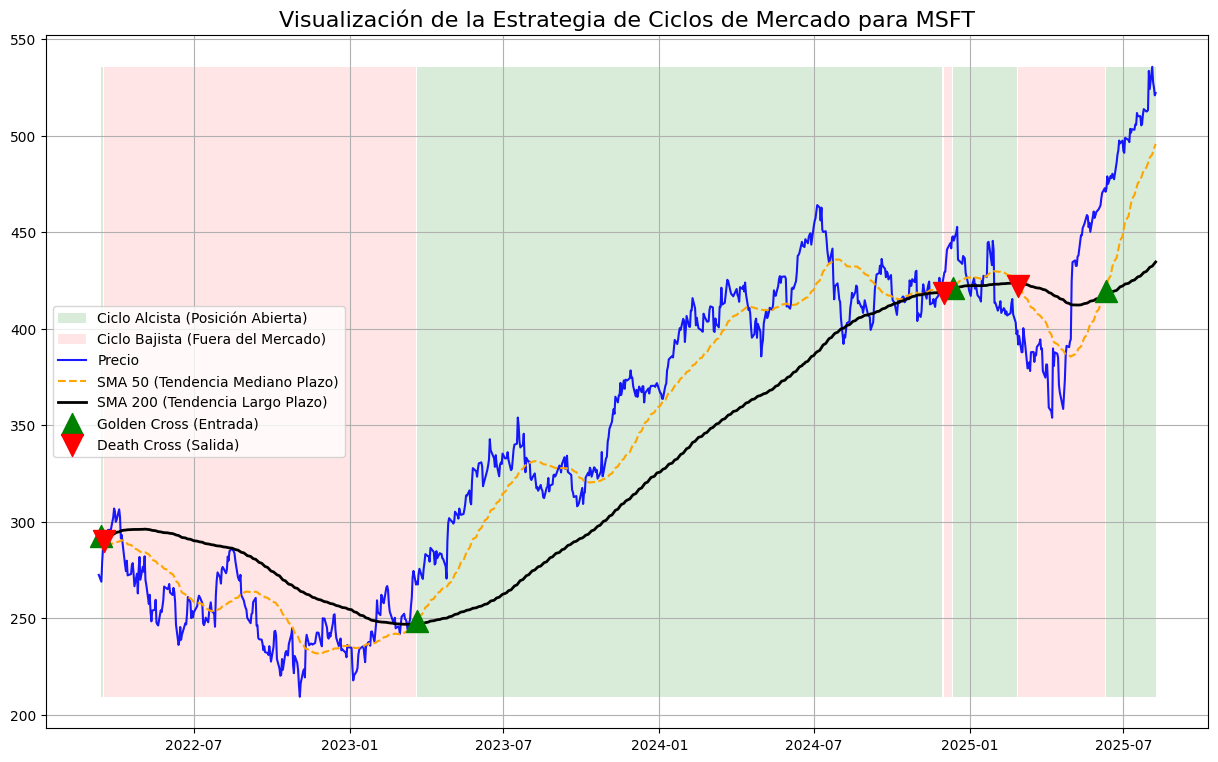


--- Resultados del Backtesting de la Estrategia de Ciclos de Mercado ---
Rentabilidad Total (Estrategia): 63.30%
Rentabilidad Total (Buy & Hold): 87.87%


In [4]:
# =================================================================
# Celda 24: Backtest y Visualización (Estrategia de Ciclos de Mercado)
# =================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import config as cfg

# --- 1. Preparación de Datos ---
# Nos aseguramos de tener las columnas necesarias
prices['Returns'] = prices[cfg.EMPRESA_PRINCIPAL].pct_change()
prices['SMA50'] = prices[cfg.EMPRESA_PRINCIPAL].rolling(window=50).mean()
prices['SMA200'] = prices[cfg.EMPRESA_PRINCIPAL].rolling(window=200).mean()
prices.dropna(inplace=True) # Es crucial eliminar NaNs para esta estrategia

# --- 2. Simulación de la Estrategia ---
# La señal es 1 si la SMA50 está por encima de la SMA200, y 0 si está por debajo.
prices['Signal'] = np.where(prices['SMA50'] > prices['SMA200'], 1, 0)
# La posición de hoy se basa en la señal de ayer para evitar mirar al futuro.
prices['Position_Final'] = prices['Signal'].shift(1).fillna(0)

# --- 3. Visualización de los Ciclos ---
print("Generando gráfico de la estrategia de ciclos de mercado...")

trade_signals = prices['Position_Final'].diff()
buy_points = prices[trade_signals == 1]
sell_points = prices[trade_signals == -1]

plt.figure(figsize=(15, 9))
plt.fill_between(prices.index, prices[cfg.EMPRESA_PRINCIPAL].min(), prices[cfg.EMPRESA_PRINCIPAL].max(), 
                 where=prices['Position_Final'] == 1, facecolor='green', alpha=0.15, label='Ciclo Alcista (Posición Abierta)')
plt.fill_between(prices.index, prices[cfg.EMPRESA_PRINCIPAL].min(), prices[cfg.EMPRESA_PRINCIPAL].max(), 
                 where=prices['Position_Final'] == 0, facecolor='red', alpha=0.1, label='Ciclo Bajista (Fuera del Mercado)')

plt.plot(prices[cfg.EMPRESA_PRINCIPAL], label='Precio', color='blue', alpha=0.9)
plt.plot(prices['SMA50'], label='SMA 50 (Tendencia Mediano Plazo)', color='orange', linestyle='--')
plt.plot(prices['SMA200'], label='SMA 200 (Tendencia Largo Plazo)', color='black', linewidth=2)

plt.scatter(buy_points.index, buy_points['SMA50'].loc[buy_points.index], marker='^', color='green', s=250, label='Golden Cross (Entrada)', zorder=5)
plt.scatter(sell_points.index, sell_points['SMA50'].loc[sell_points.index], marker='v', color='red', s=250, label='Death Cross (Salida)', zorder=5)

plt.title(f'Visualización de la Estrategia de Ciclos de Mercado para {cfg.EMPRESA_PRINCIPAL}', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

# --- 4. Cálculo de Métricas ---
prices['Strategy_Returns_Final'] = prices['Returns'] * prices['Position_Final']
prices['Strategy_Cumulative_Final'] = (1 + prices['Strategy_Returns_Final']).cumprod()
prices['BuyHold_Cumulative'] = (1 + prices['Returns']).cumprod()

print("\n--- Resultados del Backtesting de la Estrategia de Ciclos de Mercado ---")
print(f"Rentabilidad Total (Estrategia): {(prices['Strategy_Cumulative_Final'].iloc[-1] - 1) * 100:.2f}%")
print(f"Rentabilidad Total (Buy & Hold): {(prices['BuyHold_Cumulative'].iloc[-1] - 1) * 100:.2f}%")